# Reporte analítica de datos - Proyecto de Grado II

## Modelamiento de los datos para el municipio de BUGA

In [90]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from matplotlib import pyplot
from pandas import DataFrame
from pandas import concat
from pandas.plotting import lag_plot
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
import datetime as datetime
import math

In [34]:
buga_1 = pd.read_csv('../../dengue_data/Buga.csv')
df1 = pd.DataFrame(buga_1)
bugadata_2 = pd.read_csv('../../dengue_data/Buga2019.csv')
bugadata_2 = bugadata_2[bugadata_2.Ano == 2019]
df2 = pd.DataFrame(bugadata_2)

buga_data = pd.concat([df1, df2], ignore_index=True)
buga_data["FecNot"]=pd.to_datetime(buga_data['FecNot'])
buga_data = buga_data.drop(columns='Id')
buga_data.sort_index()

,MesOcurrencia,FecNot,Semana,Ano,Edad,GrupoEdad,Sexo,Barrio,Comuna
0,enero,2010-01-14,1,2010,23,15 - 44,F,LA MERCED,4
1,enero,2010-11-01,1,2010,23,15 - 44,F,EL CARMELO,6
2,enero,2010-10-01,1,2010,20,15 - 44,M,EL CARMELO,6
3,enero,2010-12-01,1,2010,6,5 - 14,F,SUCRE,3
4,enero,2010-07-01,1,2010,13,5 - 14,M,POPULAR,5
...,...,...,...,...,...,...,...,...,...
3534,octubre,2019-09-11,44,2019,12,5 - 14,M,JOSE MARIA CABAL,4
3535,octubre,2019-10-23,42,2019,10,5 - 14,F,AURES,4
3536,diciembre,2019-11-12,49,2019,28,15 - 44,F,LA HONDA,5
3537,septiembre,2019-05-10,40,2019,76,> 60,M,SUCRE,3


**Obtener el modelo 1 (2010-2018)**

In [16]:
df2 = df[df.Ano.isin([2013, 2016])]

**Obtener el modelo 2 (2017-2019)**

In [ ]:
# Se extraen los datos de Buga para 2019 y se obtiene su dataframe
bugadata_2019 = pd.read_csv('../../dengue_data/Buga2019.csv')
df3 = pd.DataFrame(bugadata_2019)
df3["FecNot"] = pd.to_datetime(df3['FecNot'])
df3 = df3[df3.Ano == 2019]

# Se extraen los datos de Buga entre 2017 y 2018, y se obtiene su dataframe
df4 = df[df.Ano.isin([2017, 2018])]

# Se concatenan los dos dataframes para formar uno solo desde 2017 a 2019
df_test = pd.concat([df4, df3])

### Obtener el modelo resultante (2013

In [42]:
def assign_zeros(nb_df) :
    day_delta = datetime.timedelta(days=1)
    start_date = datetime.date(2010, 1, 1)
    end_date = datetime.date(2020, 1, 1)

    list = []

    for i in range((end_date - start_date).days):
        date = start_date + i*day_delta
        try: 
            list.append(nb_df.at[date,'Casos'])
        except:  
            list.append(0)
            
    final_model = pd.DataFrame(columns=('Fecha', 'Casos'))

    for i in range((end_date - start_date).days):
        date = start_date + i*day_delta
        final_model.loc[len(final_model)]=[date, list[i]]
        
    return final_model

## MODELAMIENTO

### Predicciones de modelo AR

In [74]:
def AR_model(df_zeros, nb_name) :

    df_zeros['Values_shifted'] = df_zeros['Casos'].shift()

    fecha_1 = datetime.date(2016, 12, 31)
    fecha_2 = datetime.date(2017, 1, 1)

    df_train = df_zeros.loc[: fecha_1]
    df_test = df_zeros.loc[fecha_2: ]

    df_train = df_train.rename_axis('Fecha').reset_index()
    df_test = df_test.rename_axis('Fecha').reset_index()

    df_train.drop('Fecha', axis=1, inplace=True)
    df_train.dropna(inplace=True)
    df_test.drop('Fecha', axis=1, inplace=True)
    df_test.dropna(inplace=True)

    y1 = df_train.Casos.values
    X1 = df_train.Values_shifted.values

    y2 = df_test.Casos.values
    X2 = df_test.Values_shifted.values

    # Entrenamiento del modelo
    X_train, X_test = X1, X2
    y_train, y_test = y1, y2

    X_train = X_train.reshape(-1,1)
    X_test = X_test.reshape(-1,1)

    lr = LinearRegression()
    lr.fit(X_train, y_train)
    lr.coef_
    lr.intercept_
    y_pred = lr.predict(X_test)

    # Mostrar el modelo
    plt.plot(y_test[-1095:], label="Actual Values")
    plt.plot(y_pred[-1095:], label="Predicted Values")
    plt.legend()
    plt.title(nb_name)  
    plt.ylabel("Número de casos")  
    plt.show()

    # Análisis del modelo
    model = ARIMA(y_train, order=(1,0,0))
    model_fit = model.fit()
    print(model_fit.summary())

In [76]:
nb_df = buga_data[buga_data.Barrio == "SANTA BARBARA"]
nb_df = pd.DataFrame(nb_df['FecNot'].value_counts().sort_index())
nb_df.columns = ['Casos']
nb_df.index.name = 'Fecha'
df_zeros = assign_zeros(nb_df)
df_zeros.set_index('Fecha',inplace=True)

df_zeros.Casos.values

array([0, 0, 0, ..., 0, 0, 0], dtype=object)

In [112]:
def AR_model2(series, nb_name) :

    fecha_1 = datetime.date(2016, 12, 31)
    fecha_2 = datetime.date(2017, 1, 1)

    df_train = series.loc[: fecha_1]
    df_test = series.loc[fecha_2: ]

    y1 = df_train.values

    y2 = df_test.values

    # Entrenamiento del modelo
    train, test = y1, y2

    # train autoregression
    window = 1000
    model = AutoReg(train, lags=1000)
    model_fit = model.fit()
    coef = model_fit.params
    
    # walk forward over time steps in test
    history = train[len(train)-window:]
    history = [history[i] for i in range(len(history))]
    predictions = list()
    for t in range(len(test)):
        length = len(history)
        lag = [history[i] for i in range(length-window,length)]
        yhat = coef[0]
        for d in range(window):
            yhat += coef[d+1] * lag[window-d-1]
        obs = test[t]
        predictions.append(yhat)
        history.append(obs)
    rmse = np.sqrt(mean_squared_error(test, predictions))
    print('Test RMSE: %.3f' % rmse)
    # plot
    pyplot.figure(figsize=(25,5))
    pyplot.plot(test)
    pyplot.plot(predictions, color='red')
    pyplot.title(nb_name)  
    pyplot.ylabel("Número de casos") 
    pyplot.xlabel("Días a predecir") 
    pyplot.show()

Test RMSE: 0.233


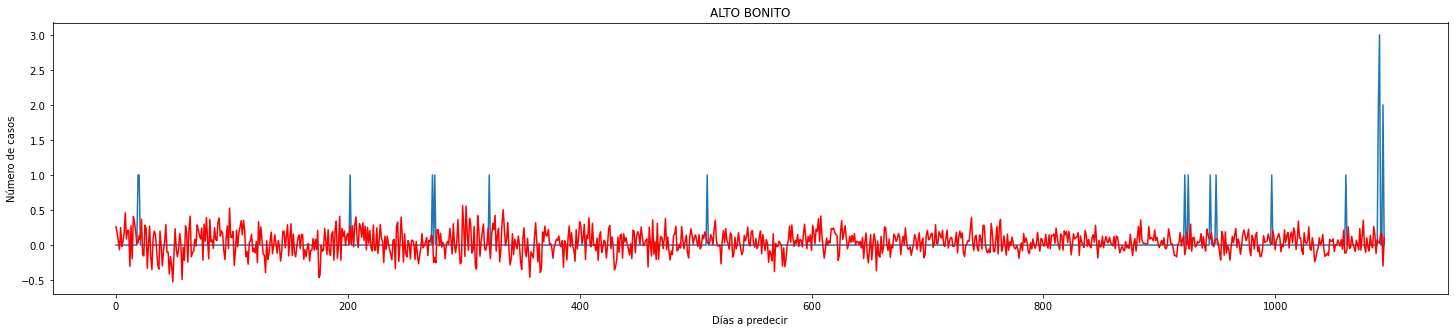

Test RMSE: 0.227


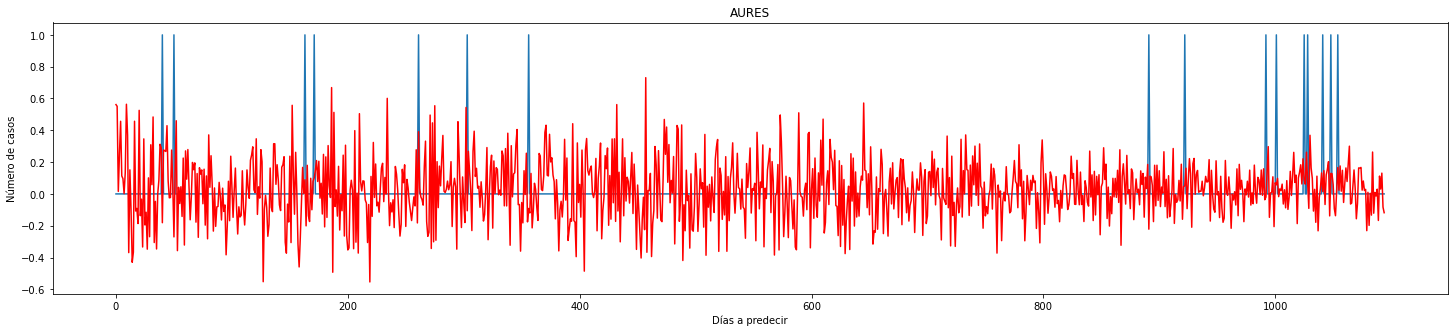

Test RMSE: 0.294


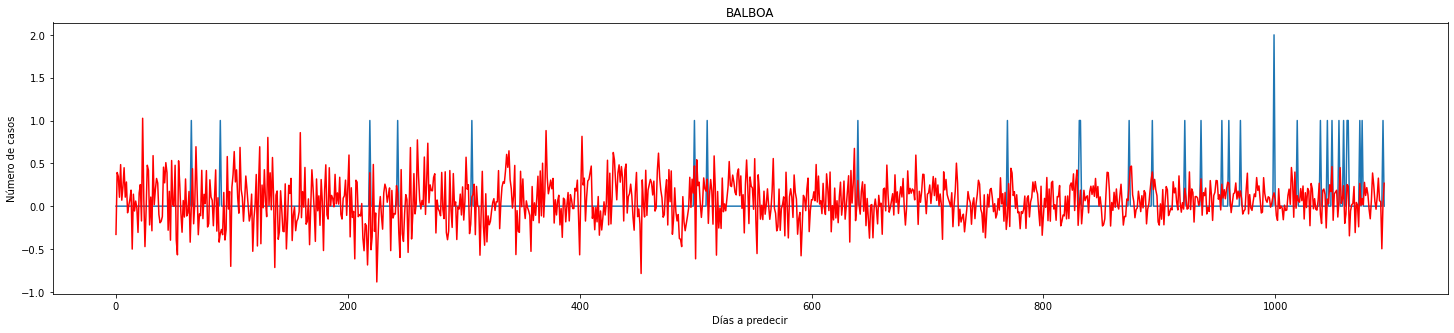

Test RMSE: 0.284


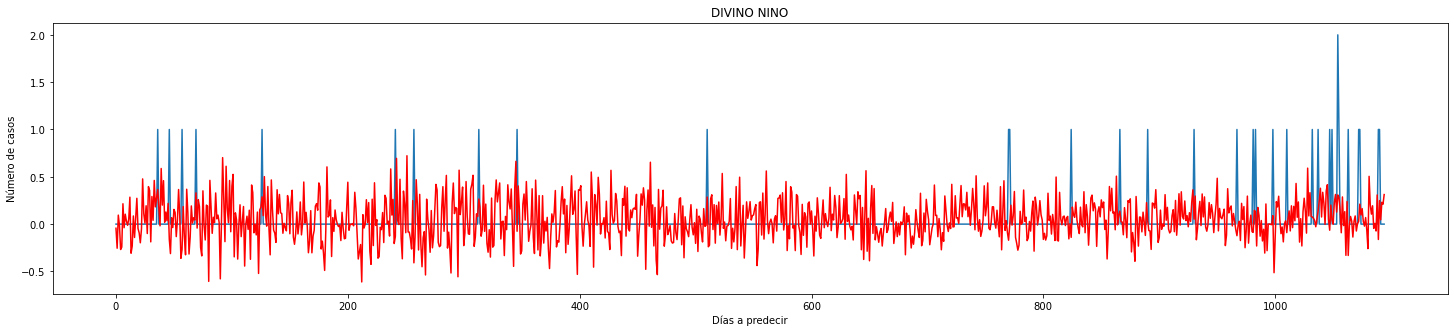

KeyboardInterrupt: 

In [113]:
neighborhoods_df = df2['Barrio'].value_counts().sort_index()

for neighborhood_name in neighborhoods_df.index :
    # Obtención conjunto entrenamiento
    nb_df = buga_data[buga_data.Barrio == neighborhood_name]
    nb_df = pd.DataFrame(nb_df['FecNot'].value_counts().sort_index())
    nb_df.columns = ['Casos']
    nb_df.index.name = 'Fecha'
    df_zeros = assign_zeros(nb_df)
    df_zeros.set_index('Fecha',inplace=True)
    
    # Ejecución del modelo AR
    AR_model2(df_zeros, neighborhood_name)